In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.shape

X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)



/kaggle/input/creditcardfraud/creditcard.csv


## Below I will select variables that have different averages for fraud vs non-fraud. I do this because Calculating pair plots of 30 variables is computationally intensive. Then I will plot a pair plot of those variables where there is a clear difference in fraud means.

Top 10 Features with largest differences: ['V1', 'V11', 'V4', 'V16', 'V14', 'V12', 'V7', 'V3', 'V10', 'V8']


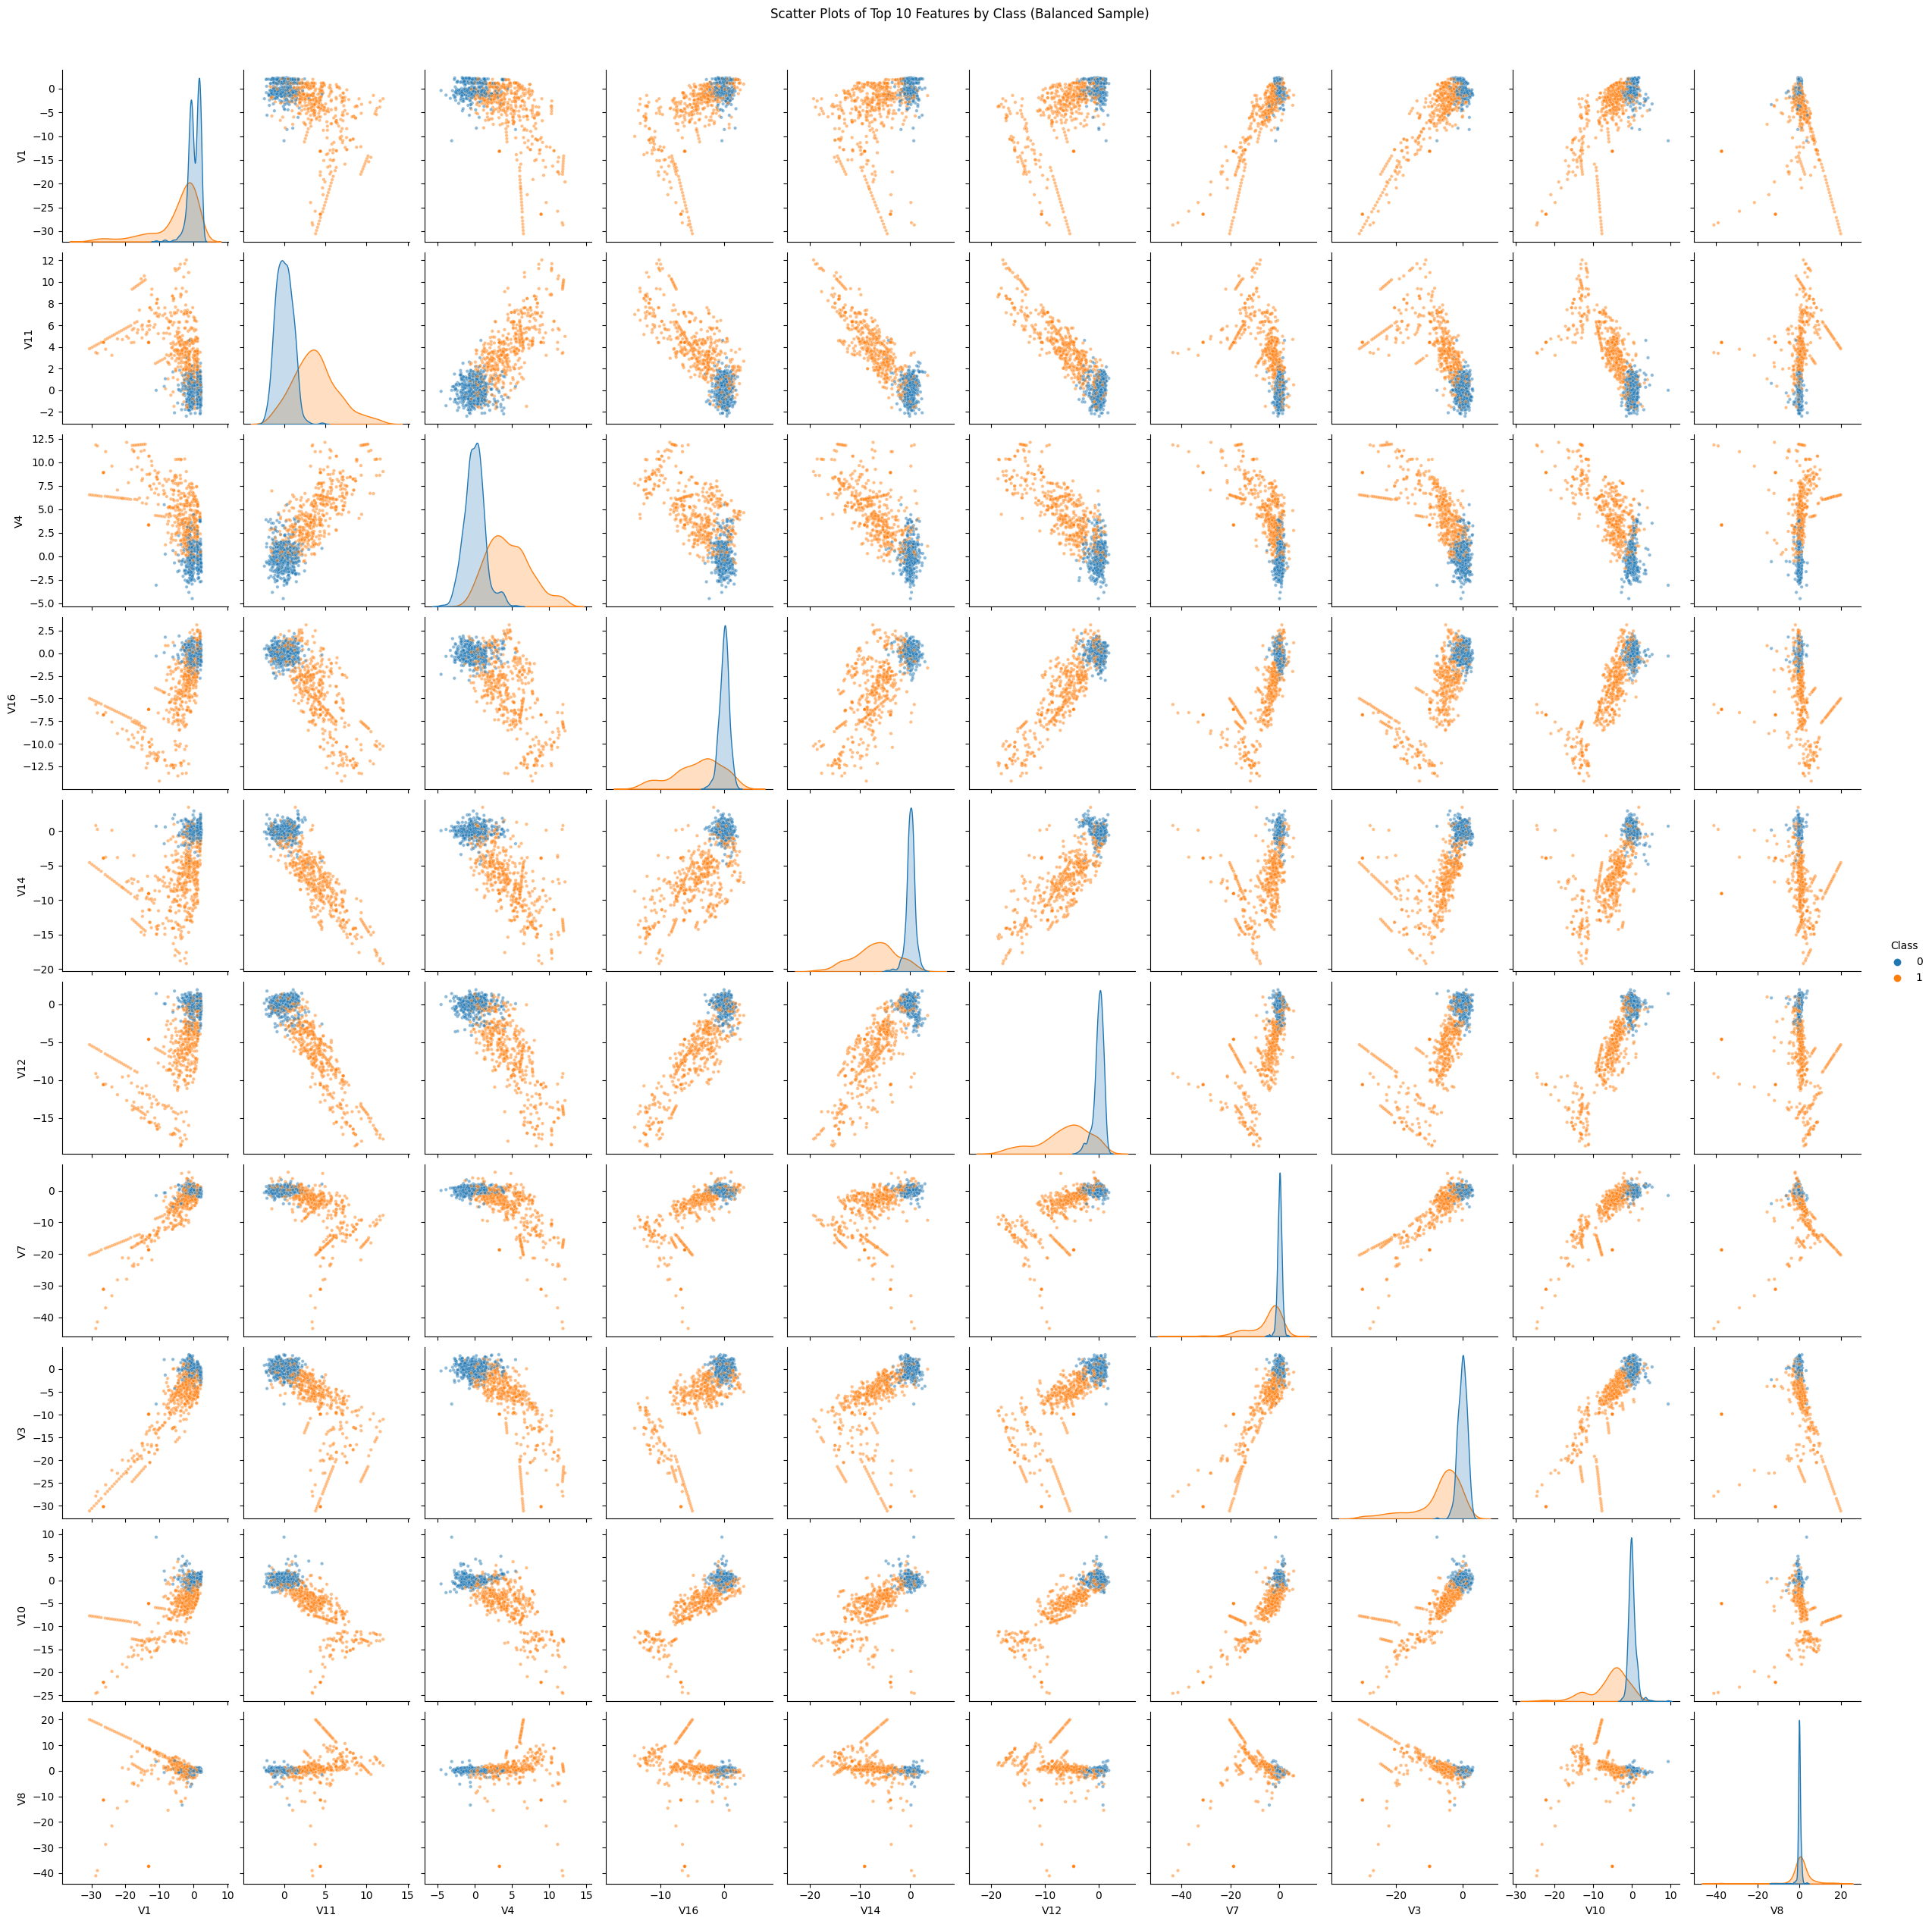

In [2]:
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# Split into features and target
X = df.drop(columns=['Class'])
y = df['Class']

# ---- Qualitative/Balanced Sampling ----
# Take all fraud samples (rare class) and a random subset of non-fraud samples
fraud_df = df[df['Class'] == 1]
non_fraud_df = df[df['Class'] == 0].sample(n=len(fraud_df)*1, random_state=42)  # 1:5 ratio (adjust as needed)

# Combine sampled data
df_sampled = pd.concat([fraud_df, non_fraud_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Update X and y based on sampled dataset
X = df_sampled.drop(columns=['Class'])
y = df_sampled['Class']

# Standardize fraud and non-fraud separately (as before)
scaler_fraud = StandardScaler()
scaler_non_fraud = StandardScaler()

fraud_data_scaled = scaler_fraud.fit_transform(X[y == 1])
non_fraud_data_scaled = scaler_non_fraud.fit_transform(X[y == 0])

fraud_data_scaled = pd.DataFrame(fraud_data_scaled, columns=X.columns)
non_fraud_data_scaled = pd.DataFrame(non_fraud_data_scaled, columns=X.columns)

# Compute group-wise mean differences
fraud_mean = fraud_data_scaled.mean(axis=0)
non_fraud_mean = non_fraud_data_scaled.mean(axis=0)

mean_df = pd.DataFrame({
    'Feature': X.columns,
    'Fraud Mean': fraud_mean,
    'Non-Fraud Mean': non_fraud_mean
})
mean_df['Difference'] = abs(mean_df['Fraud Mean'] - mean_df['Non-Fraud Mean'])

# Select top 10 features with largest differences
top_features = mean_df.nlargest(10, 'Difference')['Feature'].tolist()
print("Top 10 Features with largest differences:", top_features)

# Combine sampled data for visualization
plot_df = df_sampled[top_features + ['Class']]

# Create scatter plots (pairplot) with balanced sample
sns.pairplot(plot_df, hue='Class', plot_kws={'alpha':0.5, 's':10})
plt.suptitle('Scatter Plots of Top 10 Features by Class (Balanced Sample)', y=1.02)
plt.show()


## Above you can see that using means to select variables was a good idea. Most of these plots are separatable by machine learning Models. On the Diagnal, you can also see their distributions are also separatable.

## As you can see below, the means are different. I will use a multivariate normal distribution to predict fraud.

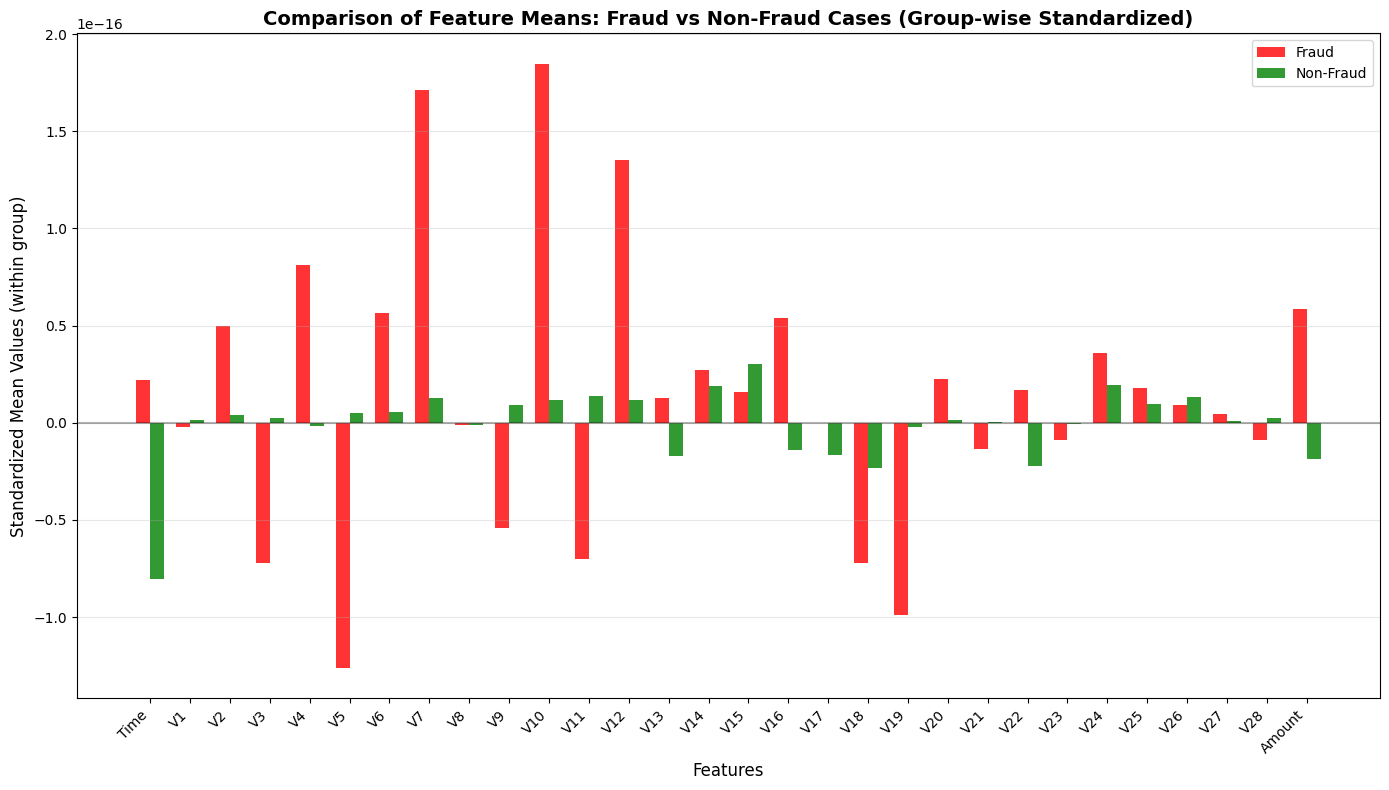

Top 10 features with largest mean differences (group-wise standardized):
       Feature    Fraud Mean  Non-Fraud Mean    Difference
V10        V10  1.848493e-16    1.196468e-17  1.728846e-16
V7          V7  1.713238e-16    1.299558e-17  1.583282e-16
V5          V5 -1.262386e-16    5.029540e-18  1.312681e-16
V12        V12  1.352556e-16    1.196468e-17  1.232909e-16
Time      Time  2.197903e-17   -8.034768e-17  1.023267e-16
V19        V19 -9.918744e-17   -2.249235e-18  9.693820e-17
V11        V11 -6.988206e-17    1.374533e-17  8.362738e-17
V4          V4  8.115336e-17   -1.905602e-18  8.305896e-17
Amount  Amount  5.861076e-17   -1.849371e-17  7.710447e-17
V3          V3 -7.213632e-17    2.249235e-18  7.438555e-17


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal

# Scale fraud and non-fraud data separately
scaler_fraud = StandardScaler()
scaler_non_fraud = StandardScaler()

fraud_data_scaled = scaler_fraud.fit_transform(X_train[y_train == 1])
non_fraud_data_scaled = scaler_non_fraud.fit_transform(X_train[y_train == 0])

fraud_data_scaled = pd.DataFrame(fraud_data_scaled, columns=X_train.columns)
non_fraud_data_scaled = pd.DataFrame(non_fraud_data_scaled, columns=X_train.columns)

# Calculate mean vectors
fraud_mean = fraud_data_scaled.mean(axis=0)
non_fraud_mean = non_fraud_data_scaled.mean(axis=0)

# Create DataFrame with mean values
mean_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Fraud Mean': fraud_mean,
    'Non-Fraud Mean': non_fraud_mean
})

# Create the bar chart visualization
plt.figure(figsize=(14, 8))

# Set the positions and width for the bars
x_pos = np.arange(len(mean_df))
width = 0.35

# Create bars
plt.bar(x_pos - width/2, mean_df['Fraud Mean'], width, label='Fraud', alpha=0.8, color='red')
plt.bar(x_pos + width/2, mean_df['Non-Fraud Mean'], width, label='Non-Fraud', alpha=0.8, color='green')

# Customize the chart
plt.xlabel('Features', fontsize=12)
plt.ylabel('Standardized Mean Values (within group)', fontsize=12)
plt.title('Comparison of Feature Means: Fraud vs Non-Fraud Cases (Group-wise Standardized)', fontsize=14, fontweight='bold')
plt.xticks(x_pos, mean_df['Feature'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Optional: Display the top 10 features with largest differences
mean_df['Difference'] = abs(mean_df['Fraud Mean'] - mean_df['Non-Fraud Mean'])
top_features = mean_df.nlargest(10, 'Difference')

print("Top 10 features with largest mean differences (group-wise standardized):")
print(top_features[['Feature', 'Fraud Mean', 'Non-Fraud Mean', 'Difference']])

## Now we have to take inverse of coverance matrix 

In [4]:
from scipy.spatial.distance import cdist
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

X = df.drop(columns=['Class'])
y = df['Class']

# Assume X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

target_ratio = 0.20 # 1:5 ratio (fraud:non-fraud = 1/5)
undersampler = RandomUnderSampler( sampling_strategy=target_ratio, random_state=41)
X_train, y_train = undersampler.fit_resample(X_train, y_train) 

# Initialize RobustScaler (scales using median & IQR, robust to outliers)
scaler = RobustScaler( )
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Separate the data for Mahalanobis distance calculations
fraud_data = X_train[y_train == 1]
non_fraud_data = X_train[y_train == 0]

# Compute means and inverse covariances
fraud_mean = np.array(fraud_data.mean(axis=0))
non_fraud_mean = np.array(non_fraud_data.mean(axis=0))
fraud_cov_inv = np.linalg.pinv(np.cov(fraud_data.T))
non_fraud_cov_inv = np.linalg.pinv(np.cov(non_fraud_data.T))


# 1. Original Mahalanobis Distance Approach
train_maha_fraud = cdist(X_train, [fraud_mean], metric='mahalanobis', VI=fraud_cov_inv).flatten()
train_maha_nonfraud = cdist(X_train, [non_fraud_mean], metric='mahalanobis', VI=non_fraud_cov_inv).flatten()
test_maha_fraud = cdist(X_test, [fraud_mean], metric='mahalanobis', VI=fraud_cov_inv).flatten()
test_maha_nonfraud = cdist(X_test, [non_fraud_mean], metric='mahalanobis', VI=non_fraud_cov_inv).flatten()

# 2. Euclidean Distance Approach
train_euc_fraud = cdist(X_train, [fraud_mean], metric='euclidean').flatten()
train_euc_nonfraud = cdist(X_train, [non_fraud_mean], metric='euclidean').flatten()
test_euc_fraud = cdist(X_test, [fraud_mean], metric='euclidean').flatten()
test_euc_nonfraud = cdist(X_test, [non_fraud_mean], metric='euclidean').flatten()

# 3. Manhattan Distance Approach
train_manh_fraud = cdist(X_train, [fraud_mean], metric='cityblock').flatten()
train_manh_nonfraud = cdist(X_train, [non_fraud_mean], metric='cityblock').flatten()
test_manh_fraud = cdist(X_test, [fraud_mean], metric='cityblock').flatten()
test_manh_nonfraud = cdist(X_test, [non_fraud_mean], metric='cityblock').flatten()


threshold = 1  # You can tweak this as needed
preds_df = pd.DataFrame()  # Initialize with true labels

def evaluate_distance_method(train_fraud_dist, train_nonfraud_dist, test_fraud_dist, test_nonfraud_dist, name):
    train_ratio = train_fraud_dist / (train_nonfraud_dist + 1e-10)
    test_ratio = test_fraud_dist / (test_nonfraud_dist + 1e-10)
    
    train_preds = (train_ratio < threshold).astype(int)
    test_preds = (test_ratio < threshold).astype(int)

    # Append test predictions to preds_df
    preds_df[f"{name}_pred"] = test_preds
    
    print(f"\n=== {name} Distance ===")
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, test_preds))
    print("ROC AUC Score:", roc_auc_score(y_test, test_preds))

    return train_preds, test_preds

# Mahalanobis
train_maha_preds, test_maha_preds = evaluate_distance_method(
    train_maha_fraud, train_maha_nonfraud, test_maha_fraud, test_maha_nonfraud, "Mahalanobis")

# Euclidean
train_euc_preds, test_euc_preds = evaluate_distance_method(
    train_euc_fraud, train_euc_nonfraud, test_euc_fraud, test_euc_nonfraud, "Euclidean")

# Manhattan
train_manh_preds, test_manh_preds = evaluate_distance_method(
    train_manh_fraud, train_manh_nonfraud, test_manh_fraud, test_manh_nonfraud, "Manhattan")




=== Mahalanobis Distance ===
Test Confusion Matrix:
[[49974  6890]
 [    3    95]]
ROC AUC Score: 0.9241107317997542

=== Euclidean Distance ===
Test Confusion Matrix:
[[56847    17]
 [   21    77]]
ROC AUC Score: 0.8927076633973792

=== Manhattan Distance ===
Test Confusion Matrix:
[[56847    17]
 [   19    79]]
ROC AUC Score: 0.9029117450300324


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import RobustScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Undersample majority class to 1:5 ratio
target_ratio = 0.50  # fraud:non-fraud = 1:5
undersampler = RandomUnderSampler(sampling_strategy=target_ratio)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

# Scale features (important for SVM and logistic regression)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define individual classifiers
clf1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
clf2 = RandomForestClassifier(n_estimators=10)
clf4 = XGBClassifier( eval_metric='logloss', use_label_encoder=False)

# Create soft voting ensemble
voting_clf = VotingClassifier(
    estimators=[
        ('lr', clf1),
        ('rf', clf2),
        ('xgb', clf4)
    ],
    voting='soft'  # Uses predicted probabilities for averaging
)

# Train ensemble
voting_clf.fit(X_train_scaled, y_train)

# Predictions
y_pred = voting_clf.predict(X_test_scaled)
y_prob = voting_clf.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1 (fraud)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Feature importance (from RandomForest and XGBoost)
if hasattr(clf2, 'feature_importances_'):
    print("\nRandomForest Feature Importances:")
    print(sorted(zip(X.columns, clf2.feature_importances_), key=lambda x: x[1], reverse=True)[:5])

if hasattr(clf4, 'feature_importances_'):
    print("\nXGBoost Feature Importances:")
    print(sorted(zip(X.columns, clf4.feature_importances_), key=lambda x: x[1], reverse=True)[:5])

Confusion Matrix:
 [[56395   469]
 [    9    89]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.16      0.91      0.27        98

    accuracy                           0.99     56962
   macro avg       0.58      0.95      0.63     56962
weighted avg       1.00      0.99      0.99     56962

ROC AUC Score: 0.9879388200130925
